In [18]:
!pip install pyvi


[notice] A new release of pip available: 22.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import numpy as np
import pandas as pd
from pyvi.ViTokenizer import ViTokenizer
import regex as re
import os
import matplotlib.pyplot as plt
import seaborn as sns
from emot.emo_unicode import UNICODE_EMOJI, EMOTICONS_EMO
from collections import Counter
import random

In [3]:
TRAIN_DATA = '../data/vihsd_dataset/train.csv'
TEST_DATA = '../data/vihsd_dataset/test.csv'

In [4]:
train_data = pd.read_csv(TRAIN_DATA)
test_data = pd.read_csv(TEST_DATA)

In [5]:
train_data.head()

,free_text,label_id
0,Em được làm fan cứng luôn rồi nè ❤️ reaction q...,0
1,Đúng là bọn mắt híp lò xo thụt :))) bên việt n...,2
2,Đậu Văn Cường giờ giống thằng sida hơn à,0
3,CÔN ĐỒ CỤC SÚC VÔ NHÂN TÍNH ĐỀ NGHI VN. NHÀ NƯ...,2
4,Từ lý thuyết đến thực hành là cả 1 câu chuyện ...,0


In [6]:
# Lọc dữ liệu để tìm comment tương ứng với id=0
comment_for_id_0 = train_data[train_data['label_id'] == 0]['free_text'].head(10)

if not comment_for_id_0.empty:
    print("Comments for ID=0:")
    for comment in comment_for_id_0:
        print(comment)
else:
    print("Không tìm thấy comment cho ID=0.")

Comments for ID=0:
Em được làm fan cứng luôn rồi nè ❤️ reaction quá hay quá cute coi mấy giờ này quá hợp lí =]]]
Đậu Văn Cường giờ giống thằng sida hơn à
Từ lý thuyết đến thực hành là cả 1 câu chuyện dài =))
Coronavirus is manmade
Đố chúng m nhận ra ai
🥰🥰🥰
Được anh ưi, lâu rồi không nghe phúc du rap 🤣
Cắt cho trẻ trâu bớt thui mà 😂😂😂
Nghe rất vô lí nhưng cực kì thuyết phục
chán ghê hong có pé 2 mới máu được, hâhha


In [7]:
# Lọc dữ liệu để tìm comment tương ứng với id=1
comment_for_id_1 = train_data[train_data['label_id'] == 1]['free_text'].head(5)

if not comment_for_id_1.empty:
    print("Comments for ID=1:")
    for comment in comment_for_id_1:
        print(comment)
else:
    print("Không tìm thấy comment cho ID=1.")

Comments for ID=1:
Lúp lúp như chó .
Dạy bơi cho cá. Bơi thì đương nhiên nó bơi được vì nó là cá. Làm sao cho nó sống được mới là điều người dân đang quan tâm.
Ý thức còn ít hơn cả số tiền trong túi t
xxx video 🔞
Đấu khẩu - Chim lợn 👍


In [8]:
# Lọc dữ liệu để tìm comment tương ứng với id=2
comment_for_id_2 = train_data[train_data['label_id'] == 2]['free_text'].head(5)

if not comment_for_id_2.empty:
    print("Comments for ID=2:")
    for comment in comment_for_id_2:
        print(comment)
else:
    print("Không tìm thấy comment cho ID=2.")

Comments for ID=2:
Đúng là bọn mắt híp lò xo thụt :))) bên việt nam t cái này ra cách đây 10 năm r và bọn t gọi là cái L :)))
CÔN ĐỒ CỤC SÚC VÔ NHÂN TÍNH ĐỀ NGHI VN. NHÀ NƯỚC VN BAN THƯỞNG.
Thế mà mình nói mấy thằng bắc kì, bọn đó lại bâu vô nói mình phân biệt!:D
Loại này cho dựa cột thôi chứ độ thế nào
Ủa chứ bữa xin lỗi khóc tế om xòm mà giờ chửi nữa rồi bó tay con này hỗn quá


In [9]:
train_data['label_id'] = train_data['label_id'].replace(2, 1)
test_data['label_id'] = train_data['label_id'].replace(2, 1)

In [10]:
X_train = train_data['free_text']
y_train = train_data['label_id'].values

X_test = test_data['free_text']
y_test = test_data['label_id'].values

In [11]:
STOPWORDS = '../data/vietnamese_stop_word/vietnamese-stopwords-dash.txt'
with open(STOPWORDS, "r", encoding="utf-8") as ins:
    stopwords = []
    for line in ins:
        dd = line.strip('\n')
        stopwords.append(dd)
    stopwords = set(stopwords)

def filter_stop_words(train_sentences, stop_words):
    new_sent = [word for word in train_sentences.split() if word not in stop_words]
    train_sentences = ' '.join(new_sent)
    return train_sentences

def check_repeated_character(text):
    text = re.sub('  +', ' ', text).strip()
    count = {}
    for i in range(len(text) - 1):
        if text[i] == text[i + 1]:
            return True
    return False

def check_space(text):  # check space in string
    for i in range(len(text)):
        if text[i] == ' ':
            return True
    return False


def check_special_character_numberic(text):
    return any(not c.isalpha() for c in text)

def remove_emoji(text):
    for emot in UNICODE_EMOJI:
        text = str(text).replace(emot, ' ')
    text = re.sub('  +', ' ', text).strip()
    return text

# Remove url
def url(text):
    text = re.sub(r'https?://\S+|www\.\S+', ' ', str(text))
    text = re.sub('  +', ' ', text).strip()
    return text

# remove special character
def special_character(text):
    text = re.sub(r'\d+', lambda m: " ", text)
    # text = re.sub(r'\b(\w+)\s+\1\b',' ', text) #remove duplicate number word
    text = re.sub("[~!@#$%^&*()_+{}“”|:\"<>?`´\-=[\]\;\\\/.,]", " ", text)
    text = re.sub('  +', ' ', text).strip()
    return text

# normalize repeated characters
def repeated_character(text):
    text = re.sub(r'(\w)\1+', r'\1', text)
    text = re.sub('  +', ' ', text).strip()
    return text

def mail(text):
    text = re.sub(r'[^@]+@[^@]+\.[^@]+', ' ', text)
    text = re.sub('  +', ' ', text).strip()
    return text

# remove mention tag and hashtag
def tag(text):
    text = re.sub(r"(?:\@|\#|\://)\S+", " ", text)
    text = re.sub('  +', ' ', text).strip()
    return text

# """Remove all mixed words and numbers"""
def mixed_word_number(text):
    text = ' '.join(s for s in text.split() if not any(c.isdigit() for c in s))
    text = re.sub('  +', ' ', text).strip()
    return text

c2e_path = os.path.join(os.getcwd(), '../data/dictionary/character2emoji.xlsx')
character2emoji = pd.read_excel(c2e_path)  # character to emoji
def convert_character2emoji(text):
    text = str(text)
    for i in range(character2emoji.shape[0]):
        text = text.replace(character2emoji.at[i, 'character'], " " + character2emoji.at[i, 'emoji'] + " ")
    text = re.sub('  +', ' ', text).strip()
    return text

e2w_path = os.path.join(os.getcwd(), '../data/dictionary/emoji2word.xlsx')
emoji2word = pd.read_excel(e2w_path)  # emoji to word

def convert_emoji2word(text):
    for i in range(emoji2word.shape[0]):
        text = text.replace(emoji2word.at[i, 'emoji'], " " + emoji2word.at[i, 'word_vn'] + " ")
    text = re.sub('  +', ' ', text).strip()
    return text

adn_path = os.path.join(os.getcwd(), '../data/dictionary/abb_dict_normal.xlsx')
abb_dict_normal = pd.read_excel(adn_path)


def abbreviation_normal(text):  # len word equal 1
    text = str(text)
    temp = ''
    for word in text.split():
        for i in range(abb_dict_normal.shape[0]):
            if str(abb_dict_normal.at[i, 'abbreviation']) == str(word):
                word = str(abb_dict_normal.at[i, 'meaning'])
        temp = temp + ' ' + word
    text = temp
    text = re.sub('  +', ' ', text).strip()
    return text

ads_path = os.path.join(os.getcwd(), '../data/dictionary/abb_dict_special.xlsx')
abb_dict_special = pd.read_excel(ads_path)


def abbreviation_special(text):  # including special character and number
    text = ' ' + str(text) + ' '
    for i in range(abb_dict_special.shape[0]):
        text = text.replace(' ' + abb_dict_special.at[i, 'abbreviation'] + ' ',
                            ' ' + abb_dict_special.at[i, 'meaning'] + ' ')
    text = re.sub('  +', ' ', text).strip()
    return text

def special_character_1(text):  # remove dot and comma
    text = re.sub("[.,?!]", " ", text)
    text = re.sub('  +', ' ', text).strip()
    return text

def abbreviation_kk(text):
    text = str(text)
    for t in text.split():
        if 'kk' in t:
            text = text.replace(t, ' ha ha ')
        else:
            if 'kaka' in t:
                text = text.replace(t, ' ha ha ')
            else:
                if 'kiki' in t:
                    text = text.replace(t, ' ha ha ')
                else:
                    if 'haha' in t:
                        text = text.replace(t, ' ha ha ')
                    else:
                        if 'hihi' in t:
                            text = text.replace(t, ' ha ha ')
    text = re.sub('  +', ' ', text).strip()
    return text

# tokenize by lib Pyvi
def tokenize(text):
    text = str(text)
    text = ViTokenizer.tokenize(text)
    return text


In [12]:
def preprocessing(text, lowercased = True):
    text = text.lower() if lowercased else text
    text = convert_character2emoji(text)
    text = url(text)
    text = mail(text)
    text = tag(text)
    text = mixed_word_number(text)
    text = special_character_1(text)  # ##remove , . ? !
    text = abbreviation_kk(text)
    text = abbreviation_special(text)
    text = convert_character2emoji(text)
    text = remove_emoji(text)
    text = repeated_character(text)
    text = special_character(text)
    text = abbreviation_normal(text)
    text = tokenize(text)
    text = filter_stop_words(text, stopwords)
    return text

In [13]:
def pre_process_features(X, y):
    X = [preprocessing(str(p)) for p in list(X)]
    for idx, ele in enumerate(X):
        if not ele:
            np.delete(X, idx)
            np.delete(y, idx)
    return X, y

In [14]:
train_X, train_y = pre_process_features(X_train, y_train)
test_X, test_y = pre_process_features(X_test, y_test)

In [15]:
from pyspark.sql import SparkSession

# Khởi tạo Spark session
spark = SparkSession.builder.appName("IE212_project").getOrCreate()

In [ ]:
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.feature import HashingTF, IDF, NGram
from pyspark.ml import Pipeline
from pyspark.sql.functions import udf
from pyspark.sql.functions import col
from pyspark.sql.types import ArrayType, StringType, StructType, StructField, IntegerType
from pyvi.ViTokenizer import ViTokenizer

# Hàm tách từ bằng pyvi
def vietnamese_tokenize(text):
    return ViTokenizer.tokenize(text).split()  # Tách từ và chuyển thành danh sách

# Đăng ký UDF (User Defined Function) để sử dụng trong Spark DataFrame
tokenize_udf = udf(vietnamese_tokenize, ArrayType(StringType()))

# Xác định schema với kiểu dữ liệu cụ thể cho các cột
schema = StructType([
    StructField("free_text", StringType(), True),
    StructField("label_id", IntegerType(), True)  # Đảm bảo label_id là IntegerType
])

# Chuyển nhãn từ numpy int64 sang Python int để tương thích với Spark
y_train = [int(label) for label in train_y]  # Nếu train_Y là numpy array
y_test = [int(label) for label in test_y]  # Nếu test_Y là numpy array

# Tạo dữ liệu dạng tuple (câu, nhãn) cho train và test
train_data = [(sentence, label) for sentence, label in zip(train_X, y_train)]
test_data = [(sentence, label) for sentence, label in zip(test_X, y_test)]

# Tạo DataFrame với schema đã xác định
train_df = spark.createDataFrame(train_data, schema)
test_df = spark.createDataFrame(test_data, schema)

# Áp dụng UDF để tách từ cho cột free_text
train_df = train_df.withColumn("words", tokenize_udf(col("free_text")))
test_df = test_df.withColumn("words", tokenize_udf(col("free_text")))

# Tạo n-grams từ các từ đã tách (ngram_range=(1,2))
ngram = NGram(n=2, inputCol="words", outputCol="ngrams")  # Tạo bigram (n=2)

# Tính TF cho n-grams
hashing_tf = HashingTF(inputCol="ngrams", outputCol="raw_features", numFeatures=2000)

# Tính IDF cho n-grams
idf = IDF(inputCol="raw_features", outputCol="features")

# Khởi tạo mô hình Decision Tree với các tham số yêu cầu
dt = DecisionTreeClassifier(featuresCol="features", labelCol="label_id", maxDepth=17, minInstancesPerNode=3)

# Tạo grid cho các tham số cần tối ưu hóa
paramGrid = ParamGridBuilder() \
    .addGrid(dt.maxDepth, [17]) \
    .addGrid(dt.minInstancesPerNode, [3]) \
    .build()

# Sử dụng CrossValidator để tìm tham số tốt nhất
evaluator = MulticlassClassificationEvaluator(
    labelCol="label_id", predictionCol="prediction", metricName="accuracy"
)

crossval = CrossValidator(
    estimator=dt,
    estimatorParamMaps=paramGrid,
    evaluator=evaluator,
    numFolds=5
)

# Tạo pipeline để xử lý dữ liệu
pipeline = Pipeline(stages=[ngram, hashing_tf, idf, crossval])

# Huấn luyện mô hình trên tập train
dt_model = pipeline.fit(train_df)


In [ ]:

# Dự đoán trên tập test
predictions = dt_model.transform(test_df)

# Đánh giá mô hình
accuracy = evaluator.evaluate(predictions)
print(f"Accuracy: {accuracy:.2f}")

precision_evaluator = MulticlassClassificationEvaluator(
    labelCol="label_id", predictionCol="prediction", metricName="weightedPrecision"
)
precision = precision_evaluator.evaluate(predictions)
print(f"Precision: {precision:.2f}")


# Tính Recall
recall_evaluator = MulticlassClassificationEvaluator(
    labelCol="label_id", predictionCol="prediction", metricName="weightedRecall"
)
recall = recall_evaluator.evaluate(predictions)
print(f"Recall: {recall:.2f}")

f1_evaluator = MulticlassClassificationEvaluator(
    labelCol="label_id", predictionCol="prediction", metricName="f1"
)
f1_score = f1_evaluator.evaluate(predictions)
print(f"F1 Score: {f1_score:.2f}")




Accuracy: 0.80
Precision: 0.70
Recall: 0.80
F1 Score: 0.74


In [22]:
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd

# Chuyển đổi DataFrame của Spark sang Pandas
preds_and_labels = predictions.select("prediction", "label_id").toPandas()

# Lấy giá trị dự đoán và nhãn
y_true = preds_and_labels["label_id"]
y_pred = preds_and_labels["prediction"]

# In classification report
print("Classification Report:")
print(classification_report(y_true, y_pred))

# In confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))


NameError: name 'predictions' is not defined

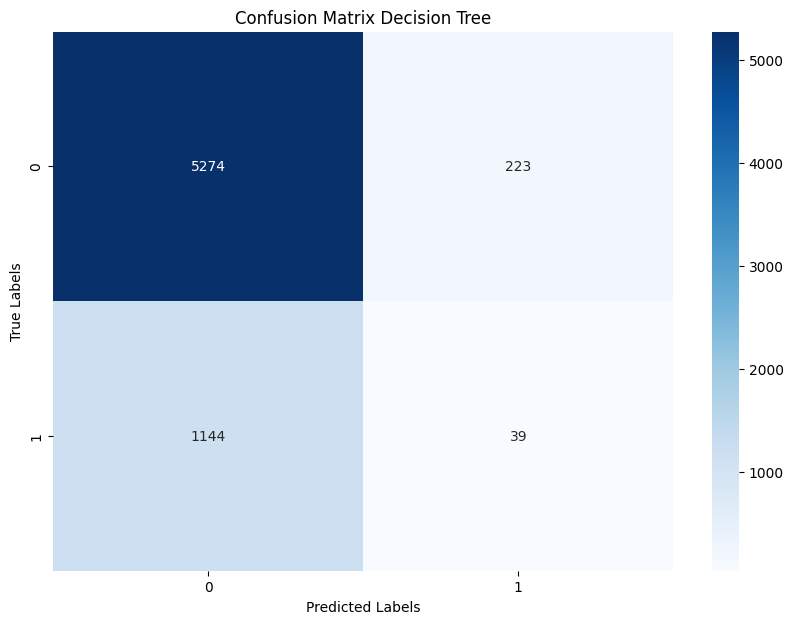

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Tạo confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Vẽ heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=sorted(set(y_true)), yticklabels=sorted(set(y_true)))
plt.title("Confusion Matrix Decision Tree")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


In [ ]:
model_path = "drive/MyDrive/IE212_project/content/DecisionTree"
dt_model.write().overwrite().save(model_path)

In [ ]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.feature import HashingTF, IDF, NGram
from pyspark.ml import Pipeline
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, StringType, StructType, StructField, IntegerType
from pyvi import ViTokenizer

# Hàm tách từ bằng pyvi
def vietnamese_tokenize(text):
    return ViTokenizer.tokenize(text).split()  # Tách từ và chuyển thành danh sách

# Đăng ký UDF (User Defined Function) để sử dụng trong Spark DataFrame
tokenize_udf = udf(vietnamese_tokenize, ArrayType(StringType()))

# Xác định schema với kiểu dữ liệu cụ thể cho các cột
schema = StructType([
    StructField("free_text", StringType(), True),
    StructField("label_id", IntegerType(), True)  # Đảm bảo label_id là IntegerType
])

# Chuyển nhãn từ numpy int64 sang Python int để tương thích với Spark
y_train = [int(label) for label in train_y]  # Nếu train_Y là numpy array
y_test = [int(label) for label in test_y]  # Nếu test_Y là numpy array

# Tạo dữ liệu dạng tuple (câu, nhãn) cho train và test
train_data = [(sentence, label) for sentence, label in zip(train_X, y_train)]
test_data = [(sentence, label) for sentence, label in zip(test_X, y_test)]

# Tạo DataFrame với schema đã xác định
train_df = spark.createDataFrame(train_data, schema)
test_df = spark.createDataFrame(test_data, schema)

# Áp dụng UDF để tách từ cho cột free_text
train_df = train_df.withColumn("words", tokenize_udf(train_df["free_text"]))
test_df = test_df.withColumn("words", tokenize_udf(test_df["free_text"]))

# Tạo n-grams từ các từ đã tách (ngram_range=(1,2))
ngram = NGram(n=2, inputCol="words", outputCol="ngrams")  # Tạo bigram (n=2)

# Tính TF cho n-grams
hashing_tf = HashingTF(inputCol="ngrams", outputCol="raw_features", numFeatures=2000)

# Tính IDF cho n-grams
idf = IDF(inputCol="raw_features", outputCol="features")

# Khởi tạo mô hình Logistic Regression với các tham số yêu cầu (bỏ tham số solver)
lr = LogisticRegression(featuresCol="features", labelCol="label_id", maxIter=20, regParam=0.3)

# Tạo grid cho các tham số cần tối ưu hóa
paramGrid = ParamGridBuilder() \
    .addGrid(lr.maxIter, [20]) \
    .addGrid(lr.regParam, [0.3]) \
    .build()

# Sử dụng CrossValidator để tìm tham số tốt nhất
evaluator = MulticlassClassificationEvaluator(
    labelCol="label_id", predictionCol="prediction", metricName="accuracy"
)

crossval = CrossValidator(
    estimator=lr,
    estimatorParamMaps=paramGrid,
    evaluator=evaluator,
    numFolds=5  \
)

# Tạo pipeline để xử lý dữ liệu
pipeline = Pipeline(stages=[ngram, hashing_tf, idf, crossval])

# Huấn luyện mô hình trên tập train
lr_model = pipeline.fit(train_df)

# Dự đoán trên tập test
predictions = lr_model.transform(test_df)




In [ ]:
# Đánh giá mô hình
accuracy = evaluator.evaluate(predictions)
print(f"Accuracy: {accuracy:.2f}")

precision_evaluator = MulticlassClassificationEvaluator(
    labelCol="label_id", predictionCol="prediction", metricName="weightedPrecision"
)
precision = precision_evaluator.evaluate(predictions)
print(f"Precision: {precision:.2f}")


# Tính Recall
recall_evaluator = MulticlassClassificationEvaluator(
    labelCol="label_id", predictionCol="prediction", metricName="weightedRecall"
)
recall = recall_evaluator.evaluate(predictions)
print(f"Recall: {recall:.2f}")

f1_evaluator = MulticlassClassificationEvaluator(
    labelCol="label_id", predictionCol="prediction", metricName="f1"
)
f1_score = f1_evaluator.evaluate(predictions)
print(f"F1 Score: {f1_score:.2f}")

Accuracy: 0.81
Precision: 0.71
Recall: 0.81
F1 Score: 0.74


In [ ]:
preds_and_labels = predictions.select("prediction", "label_id").toPandas()

# Lấy giá trị dự đoán và nhãn
y_true = preds_and_labels["label_id"]
y_pred = preds_and_labels["prediction"]

# In classification report
print("Classification Report:")
print(classification_report(y_true, y_pred))

# In confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.98      0.90      5497
           1       0.19      0.02      0.04      1183

    accuracy                           0.81      6680
   macro avg       0.51      0.50      0.47      6680
weighted avg       0.71      0.81      0.74      6680

Confusion Matrix:
[[5402   95]
 [1160   23]]


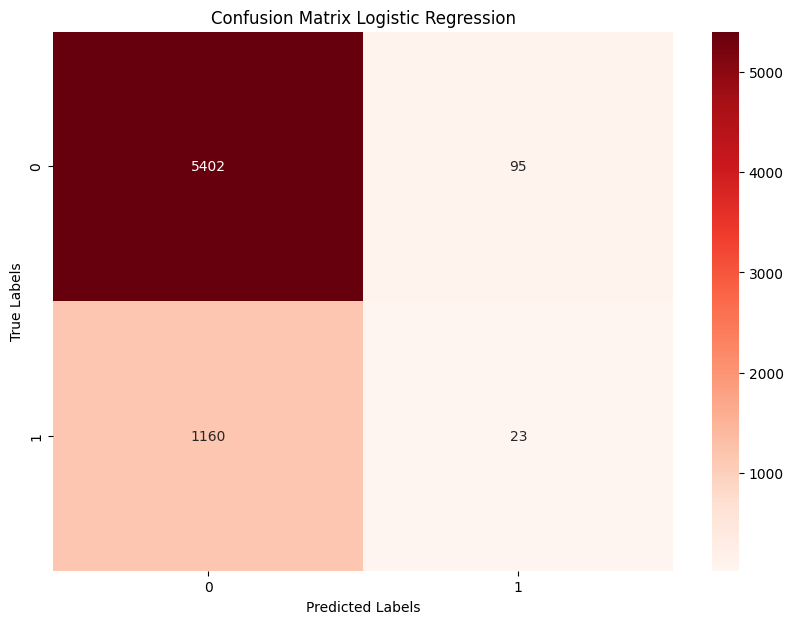

In [ ]:
# Tạo confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Vẽ heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Reds", xticklabels=sorted(set(y_true)), yticklabels=sorted(set(y_true)))
plt.title("Confusion Matrix Logistic Regression")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

In [ ]:
model_path = "drive/MyDrive/IE212_project/content/LogisiticRegression"
lr_model.write().overwrite().save(model_path)
